In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import data_reading, music_generation
from models import music_generation_gru
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
SEQ_LEN = 48
RESOLUTION = 12
TRAIN_SPLIT = 0.8
HIDDEN_SIZE = 512
BATCH_SIZE = 64
N_LAYERS = 6
CUT_TIME_RATIO = 0.1
TEST_FILE_NUMBER = 10
CUTOFF_P = 1.5
PROJECT_DIR ="D:/522 project"
PPR_DIR = "lpd_5_pianoroll"
SAVE_DIR = "./gru_unnormalized_piano/music"
#with open(SCALER_DICT_SAVE_PATH, "rb") as file:
#    scaler_dict = pickle.load(file)
scaler_dict = None
track_order=["Piano"]
PATH = os.path.join(PROJECT_DIR, PPR_DIR)
MODEL_STATE_PATH = "./P_gru_trained_r12s48d27e12"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = music_generation_gru.MusicGRU(track_order, HIDDEN_SIZE, BATCH_SIZE, N_LAYERS, DEVICE)
model.load_state_dict(torch.load(MODEL_STATE_PATH))
model.to(DEVICE)


MusicGRU(
  (gru): GRU(128, 512, num_layers=6, batch_first=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=1536, bias=True)
  (bn2): BatchNorm1d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=1536, out_features=128, bias=True)
)

In [3]:
all_files_list = data_reading.read_all_npzs(PATH, shuffle=True)
all_files_list = all_files_list[:TEST_FILE_NUMBER]
all_pianorolls = data_reading.read_and_preprocess_and_filter_pianorolls(all_files_list, track_order, SEQ_LEN, RESOLUTION, True)

In [6]:
sample_pianoroll = all_pianorolls[4]

[<AxesSubplot:xlabel='time (beat)', ylabel='Piano\n\npitch'>]

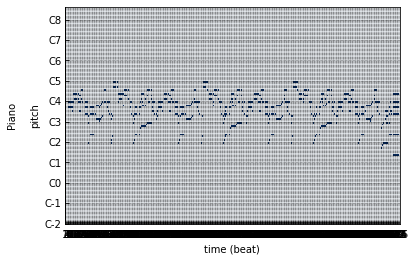

In [7]:
sample_pianoroll.plot()

In [8]:
prelude_dict, rest_dict = music_generation.cut_prelude(sample_pianoroll, 0.2)
predict_time_step = rest_dict["Piano"].shape[0]
print(predict_time_step)
generated_part_dict = music_generation.music_generation_rnn(model, scaler_dict, track_order
                                                                , prelude_dict, predict_time_step
                                                                , DEVICE)


4570


In [9]:
print(generated_part_dict)

{'Piano': tensor([[-30.0687, -29.9458, -29.9651,  ..., -30.0701, -29.9688, -30.0166],
        [-44.8406, -44.6298, -44.6288,  ..., -44.8347, -44.7624, -44.8252],
        [-41.1268, -40.9572, -41.0186,  ..., -41.1596, -41.0884, -41.1431],
        ...,
        [-54.6135, -54.3116, -54.4538,  ..., -54.7058, -54.6168, -54.7789],
        [-54.6124, -54.3105, -54.4526,  ..., -54.7048, -54.6156, -54.7777],
        [-54.6084, -54.3065, -54.4486,  ..., -54.7007, -54.6116, -54.7737]],
       device='cuda:0')}


In [10]:
print(prelude_dict)

{'Piano': tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])}


In [45]:
binarized_new_music_dict = music_generation.binarize_generated_music_dict(generated_part_dict,{"Piano":0.0000001}, True)
new_music_dict = music_generation.combine_tracks_dict(prelude_dict, binarized_new_music_dict)
new_music_mt = music_generation.create_multitrack(new_music_dict, RESOLUTION)
new_music_mt.binarize()

Piano mean:  tensor(0.0121, device='cuda:0')


Multitrack(name='Generated', resolution=12, tracks=[BinaryTrack(name='Piano', program=0, is_drum=False, pianoroll=array(shape=(5712, 128), dtype=bool))])

In [46]:
new_music_dict

{'Piano': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])}

[<AxesSubplot:xlabel='time (beat)', ylabel='Piano\n\npitch'>]

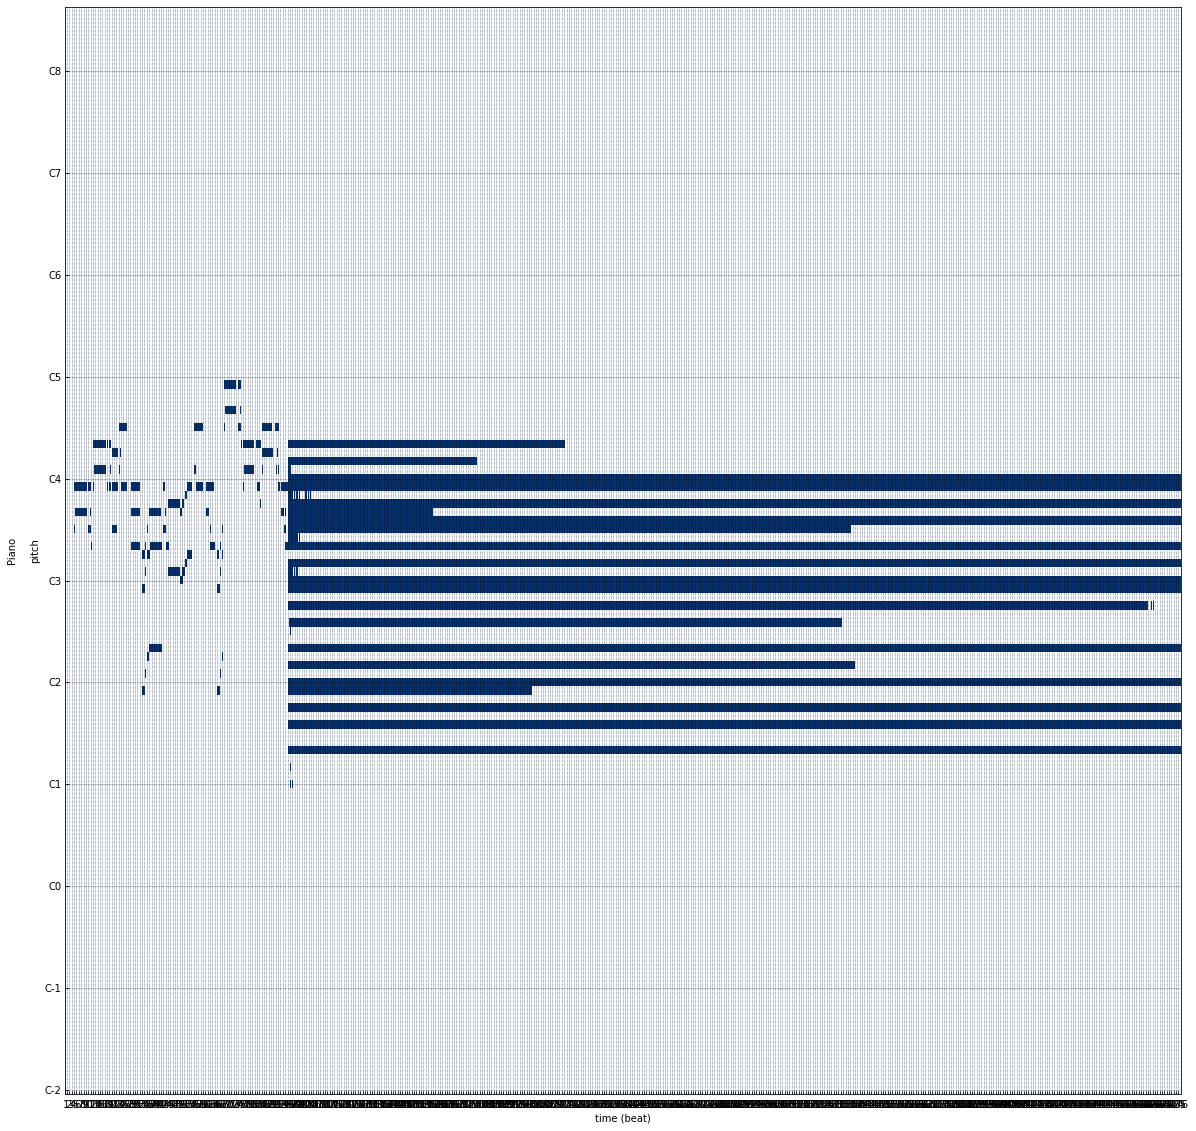

In [47]:
plt.rcParams["figure.figsize"] = (20,20)
new_music_mt.plot()

In [159]:
new_music_mt.write("experiment.mid")

In [102]:
all_files_list = data_reading.read_all_npzs(PATH, shuffle=True)
all_files_list = all_files_list[:TEST_FILE_NUMBER]
all_pianorolls = data_reading.read_and_preprocess_and_filter_pianorolls(all_files_list, track_order, SEQ_LEN, RESOLUTION)


for i, pianoroll in enumerate(all_pianorolls):
    prelude_dict, rest_dict = music_generation.cut_prelude(pianoroll, CUT_TIME_RATIO)
    predict_time_step = rest_dict["Piano"].shape[0]
    generated_part_dict = music_generation.music_generation_rnn(model, scaler_dict, track_order
                                                                , prelude_dict, predict_time_step
                                                                , DEVICE)
    new_music_dict = music_generation.combine_tracks_dict(prelude_dict, generated_part_dict)
    new_music_dict = music_generation.binarize_generated_music_dict(new_music_dict, CUTOFF_P)
    new_music_mt = music_generation.create_multitrack(new_music_dict, RESOLUTION)
    pianoroll.write(os.path.join(SAVE_DIR, f"{i} original.mid"))
    new_music_mt.write(os.path.join(SAVE_DIR, f"{i} generated.mid"))

Piano mean:  tensor(2.2844)
Piano mean:  tensor(3.4204)
Piano mean:  tensor(2.3850)
Piano mean:  tensor(2.2255)
Piano mean:  tensor(2.2038)
Piano mean:  tensor(3.1953)
Piano mean:  tensor(2.1908)
Piano mean:  tensor(3.1835)
Piano mean:  tensor(3.1192)
